In [39]:
import os
os.chdir(r'D:\hft\portfolio-opt')
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cvxopt

In [40]:
#preset parameters
threshold=0.6
centrality=10

In [41]:
#get composites
df=pd.ExcelFile(r'D:\hft\portfolio-opt\stox_data123.xlsx').parse('composite price')
df.set_index('date',inplace=True)

In [42]:
#get stoxx50 index
sx5e=pd.ExcelFile(r'D:\hft\portfolio-opt\stox_data123.xlsx').parse('sx5e')
sx5e.set_index('Date',inplace=True)
sx5e.index=pd.to_datetime(sx5e.index)
sx5e.columns=['SX5E']

In [43]:
#get stoxx50 composites
components=df.columns.tolist()

In [44]:
#merge
metadata=df.merge(sx5e,left_index=True,right_index=True,how='inner')

&nbsp;
### In Sample
&nbsp;

In [45]:
#create graph adt
def create_graph(components,correlation,threshold):
    
    graph=nx.Graph()    
    
    #connect two vertices if correlation larger than the threshold
    for i in range(len(components)):
        for j in range(i+1,len(components)):
            if correlation.at[components[i],components[j]]>threshold:
                graph.add_edge(components[i],components[j],
                               weight=correlation.at[components[i],components[j]])
                graph.add_edge(components[j],components[i],
                               weight=correlation.at[components[i],components[j]])
    
    #fix layout for viz
    layout=nx.spring_layout(graph)
    
    return graph,layout

In [46]:
#take 60% for in sample data
data=metadata['2014':'2016'].copy()

#get percentage return
pctreturn=data.pct_change().dropna()

#get correlation
correlation=pctreturn[components].corr()

#pre-processing
graph,layout=create_graph(components,correlation,threshold)

&nbsp;
### Degeneracy Ordering
&nbsp;

In [47]:
#get independent vertex set
def degeneracy_ordering(graph,components):
    
    #degeneracy ordering
    degeneracy=dict(sorted(nx.core_number(graph).items(),
                           key=lambda x:x[1]))
        
    #create independent vertex set
    independence=[]
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)
        
    #add vertices not in graph
    leftout=[i for i in components if i not in graph.nodes]
    
    return independence,leftout

In [48]:
#find optimal threshold for correlation
def find_optimal_threshold(itr,data,components,correlation):
    
    optimal=[]
    for threshold_itr in itr:

        graph,_=create_graph(components,correlation,threshold_itr)        
        independence,leftout=degeneracy_ordering(graph,components)
        
        #compute sharpe ratio
        temp=data[leftout+independence].sum(axis=1).pct_change().dropna()
        optimal.append(temp.mean()/temp.std())
    
    #viz
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.bar(np.arange(0.5,0.7,0.01),optimal,
            width=0.008,color='#F9CDAD')
    plt.title('Optimal Correlation')
    plt.xlabel('Correlation')
    plt.ylabel('Sharpe Ratio')
    plt.show()

In [49]:
#get independent vertex set
independence,leftout=degeneracy_ordering(graph,components)
data['degeneracy']=data[leftout+independence].sum(axis=1)

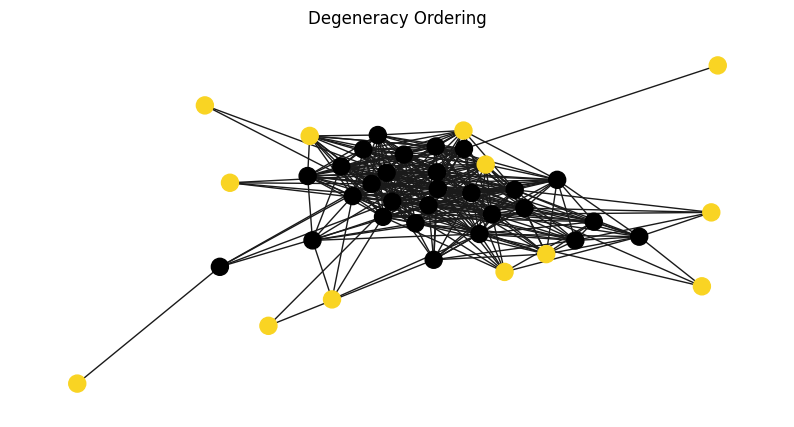

In [50]:
#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in independence:
        color.append('#000000')
    else:
        color.append('#F9D423')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Degeneracy Ordering')
plt.show()

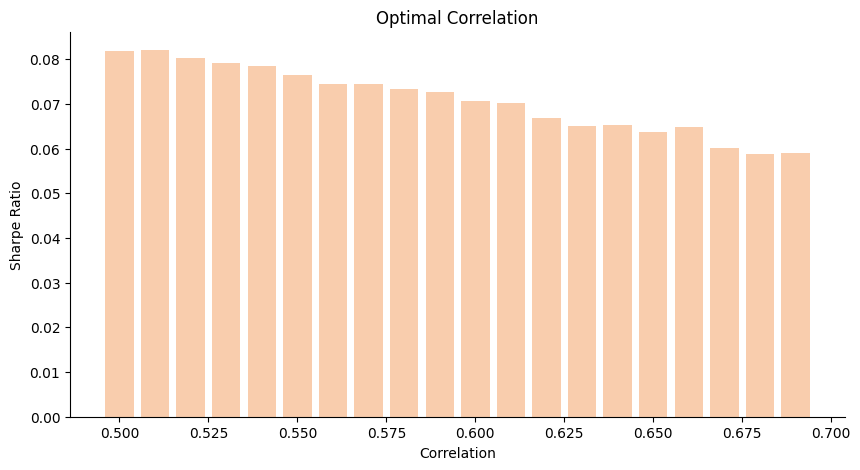

In [51]:
find_optimal_threshold(np.arange(0.5,0.7,0.01),
                       data,components,correlation)

&nbsp;
### Clique Centrality
&nbsp;

In [52]:
#use cross maximal clique centrality to construct the portfolio
def clique_centrality(graph,centrality):
    
    #compute cross maximal clique centrality
    cliques=list(nx.find_cliques(graph))

    D={}
    for ii in set([j for i in cliques for j in i]):
        D[ii]=[j for i in cliques for j in i].count(ii)

    #select vertices with centrality larger than the threshold
    clique_selected=[i[0] for i in D.items() if i[1]>centrality]
    
    return clique_selected

In [53]:
#find optimal threshold for correlation and centrality
def find_optimal_heat(itr1,itr2,data,components,correlation):
    
    #create dataframe for heatmap
    heat=pd.DataFrame(index=itr1)
    for i in itr2:
        heat[round(i,2)]=np.nan

    for threshold_itr in itr2:
        for centrality_itr in itr1:
            
            graph,_=create_graph(components,correlation,threshold_itr)        
            cliques=list(nx.find_cliques(graph))
            
            #efficient execution when no clique is found
            if cliques:
                
                #compute cross maximal clique centrality
                clique_selected=clique_centrality(graph,centrality_itr)
                
                #compute sharpe ratio
                temp=data[clique_selected].sum(axis=1).pct_change().dropna()
                heat.at[round(centrality_itr,2),
                        round(threshold_itr,2)]=temp.mean()/temp.std()
            else:
                pass
    
    #viz   
    heatmap(heat)

    
#create heatmap seaborn style
def heatmap(df,fig_size=(10,5),fontsize=0.8):
        
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)

    sns.set(font_scale=fontsize)
    
    #viz
    sns.heatmap(df,cmap=plt.cm.magma_r,
                robust=True,
                xticklabels=df.columns,
                yticklabels=df.index,
                ax=ax)
    
    #color bar title
    ax.collections[0].colorbar.set_label('Sharpe Ratio\n \n',rotation=270)
    
    plt.title('Optimal Correlation & Centrality')
    plt.xlabel('Correlation')
    plt.ylabel('Centrality')
    sns.set()
    
    plt.show()
    plt.style.use('default')

In [54]:
#use cross maximal clique centrality to construct the portfolio
clique_selected=clique_centrality(graph,centrality)
data['clique']=data[clique_selected].sum(axis=1)

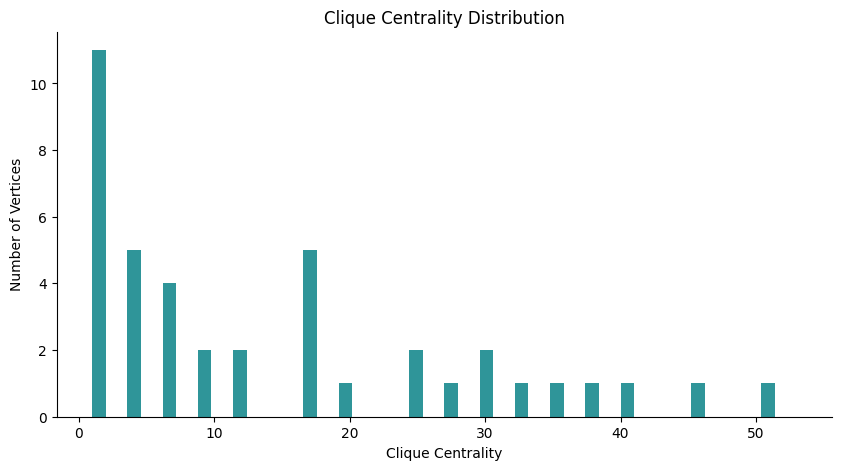

In [55]:
#viz clique centrality distribution
cliques=list(nx.find_cliques(graph))
dic={}
for ii in set([j for i in cliques for j in i]):
    dic[ii]=[j for i in cliques for j in i].count(ii)
        
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(dic.values(),width=1,bins=20,color='#2F9599')

plt.title('Clique Centrality Distribution')
plt.xlabel('Clique Centrality')
plt.ylabel('Number of Vertices')
plt.show()

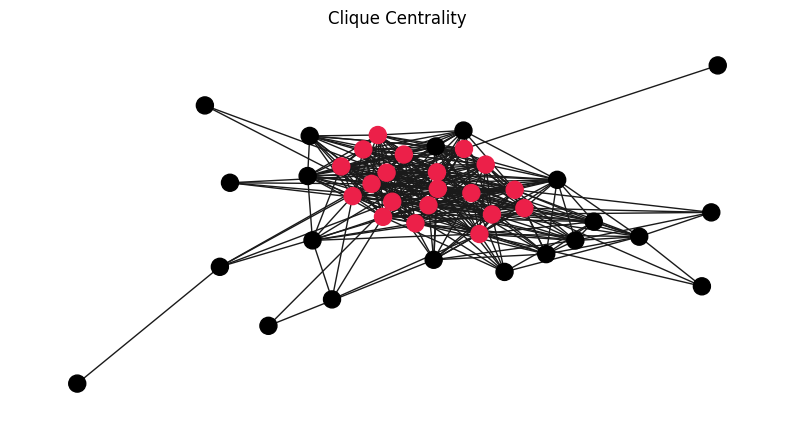

In [56]:
#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in clique_selected:
        color.append('#000000')
    else:
        color.append('#EC2049')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Clique Centrality')
plt.show()

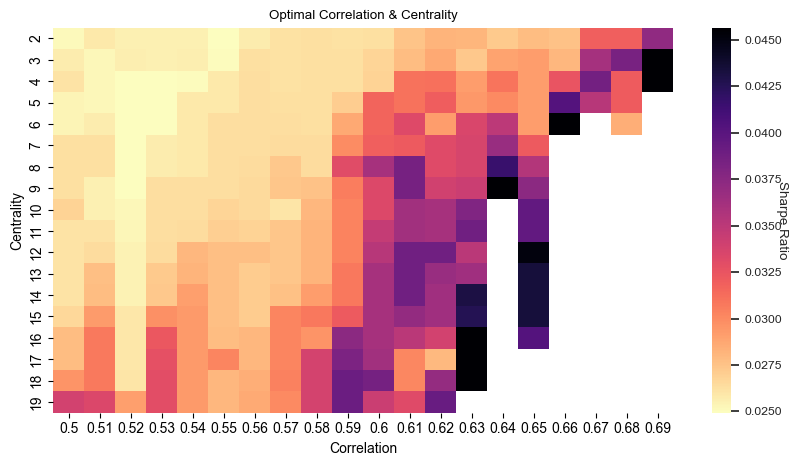

In [57]:
#viz optimal thresholds of correlation and centrality
find_optimal_heat(range(2,20),np.arange(0.5,0.7,0.01),
                  data,components,correlation)

&nbsp;
### Markowitz Optimization
&nbsp;

Using linear program with random cost, you can see details at the documentation of CVXOPT.

http://cvxopt.org/userguide/coneprog.html#quadratic-programming

&nbsp;

In [58]:
#find global maximum
def markowitz_optimization(pctreturn,components):

    #hide progress output
    cvxopt.solvers.options['show_progress']=False

    #create covariance matrix
    covariance=cvxopt.matrix(np.cov(np.array(pctreturn[components].T)))

    #number of assets
    assets=len(components)

    #realized return
    mean_return=cvxopt.matrix(pctreturn[components].mean(axis=0))

    #all weights should be larger than 0
    inequality_coeff=cvxopt.matrix(0.0,(assets,assets))
    inequality_coeff[::assets+1]=-1.0
    inequality_value=cvxopt.matrix(0.0,(assets,1))

    #sum of all weights equal to one
    equality_coeff=cvxopt.matrix(1.0,(1,assets))
    equality_value=cvxopt.matrix(1.0)

    #risk aversion parameter
    miu=1

    #maximize sharpe ratio
    max_sharpe=cvxopt.solvers.qp(P=cvxopt.matrix(miu*covariance),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']

    #minimize standard deviation
    min_variance=cvxopt.solvers.qp(P=cvxopt.matrix(covariance), 
                           q=cvxopt.matrix(0.0,(assets,1)),
                           G=inequality_coeff, 
                           h=inequality_value, 
                           A=equality_coeff, 
                           b=equality_value)['x']

    #maximize realized return
    max_return=cvxopt.solvers.qp(P=cvxopt.matrix(0.0,(assets,assets)),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']
    
    return (max_sharpe,min_variance,max_return)

In [59]:
#markowitz portfolio optimization
max_sharpe,min_variance,max_return=markowitz_optimization(pctreturn,components)
data['sharpe']=np.dot(np.mat(data[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data['variance']=np.dot(np.mat(data[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data['return']=np.dot(np.mat(data[components]),np.mat(max_return)).reshape(-1,).tolist()[0]

#create equal weight index
data['equal']=data[components].sum(axis=1)

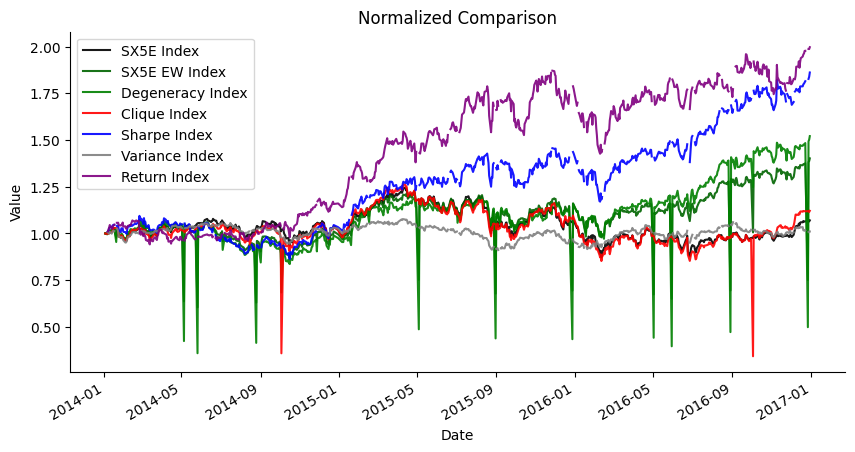

In [61]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data['SX5E']/data['SX5E'].iloc[0]).plot(label='SX5E Index',alpha=0.9,color='black')
(data['equal']/data['equal'].iloc[0]).plot(label='SX5E EW Index',alpha=0.9,color='darkgreen')
(data['degeneracy']/data['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.9,color='green')
(data['clique']/data['clique'].iloc[0]).plot(label='Clique Index',alpha=0.9,color='red')
(data['sharpe']/data['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.9,color='blue')
(data['variance']/data['variance'].iloc[0]).plot(label='Variance Index',alpha=0.9,color='grey')
(data['return']/data['return'].iloc[0]).plot(label='Return Index',alpha=0.9,color='purple')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

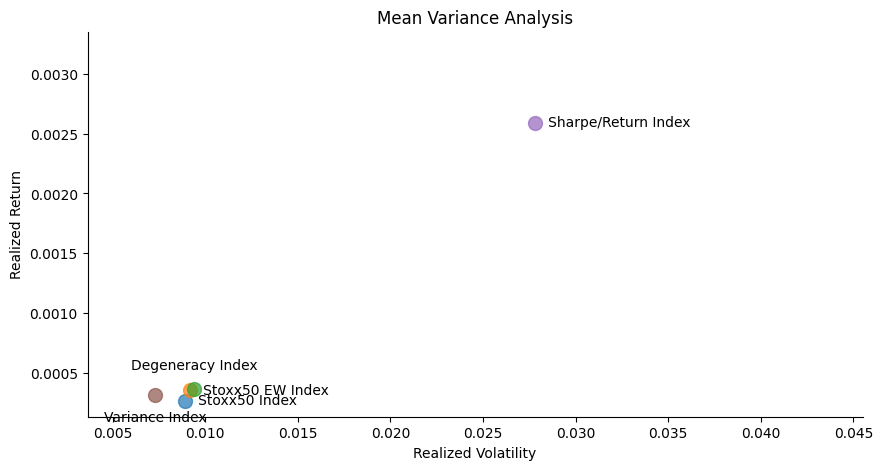

In [30]:
#mean variance analysis
comparison={}

for i in ['SP100','equal','degeneracy','clique','sharpe','variance','return']:
    comparison[i]=(data[i].pct_change().dropna().std(), 
          data[i].pct_change().dropna().mean())
    
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter(comparison['SP100'][0],comparison['SP100'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Stoxx50 Index', xy=(comparison['SP100'][0],comparison['SP100'][1]),
             ha='left',va='center')
plt.scatter(comparison['equal'][0],comparison['equal'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Stoxx50 EW Index', xy=(comparison['equal'][0],comparison['equal'][1]),
             ha='left',va='center')
plt.scatter(comparison['degeneracy'][0],comparison['degeneracy'][1],
            s=100,alpha=0.7)
plt.annotate(text='Degeneracy Index\n', xy=(comparison['degeneracy'][0],comparison['degeneracy'][1]),
             ha='center',va='bottom')
plt.scatter(comparison['clique'][0],comparison['clique'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Clique Index', xy=(comparison['clique'][0],comparison['clique'][1]),
             ha='left',va='center')
plt.scatter(comparison['sharpe'][0],comparison['sharpe'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Sharpe/Return Index', xy=(comparison['sharpe'][0],comparison['sharpe'][1]),
             ha='left',va='center')
plt.scatter(comparison['variance'][0],comparison['variance'][1],
            s=100,alpha=0.7)
plt.annotate(text='\nVariance Index', xy=(comparison['variance'][0],comparison['variance'][1]),
             ha='center',va='top')

plt.xlim(min([i[0] for i in comparison.values()])*0.5, 
         max([i[0] for i in comparison.values()])*1.05)
plt.ylim(min([i[1] for i in comparison.values()])*0.5, 
         max([i[1] for i in comparison.values()])*1.05)
plt.title('Mean Variance Analysis')
plt.xlabel('Realized Volatility')
plt.ylabel('Realized Return')
plt.show()


&nbsp;
### Out of Sample
&nbsp;

In [31]:
#take 30% for outta sample data
data=metadata['2019':].copy()

#get percentage return
pctreturn=data.pct_change().dropna()

#get correlation
correlation=pctreturn[components].corr()

#pre-processing
graph,layout=create_graph(components,correlation,threshold)

In [33]:
#generate indices
data['degeneracy']=data[leftout+independence].sum(axis=1)
data['clique']=data[clique_selected].sum(axis=1)
data['sharpe']=np.dot(np.mat(data[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data['variance']=np.dot(np.mat(data[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data['return']=np.dot(np.mat(data[components]),np.mat(max_return)).reshape(-1,).tolist()[0]
data['equal']=data[components].sum(axis=1)

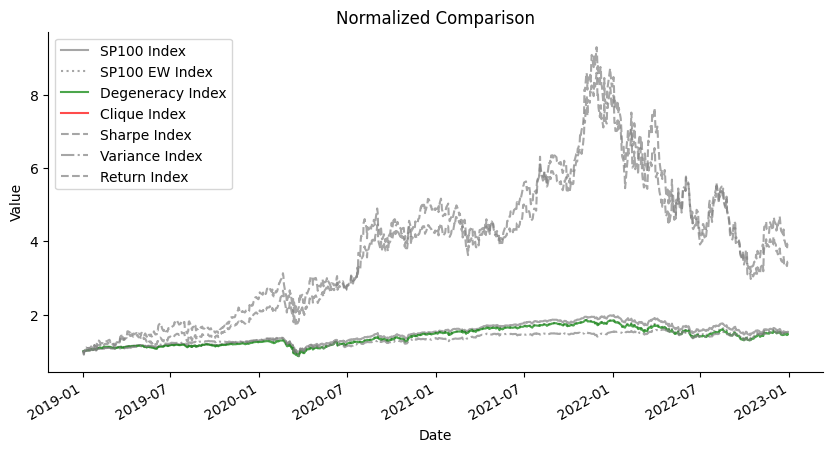

In [35]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data['SP100']/data['SP100'].iloc[0]).plot(label='SP100 Index',alpha=0.7,color='grey')
(data['equal']/data['equal'].iloc[0]).plot(label='SP100 EW Index',alpha=0.7,color='grey',linestyle=':')
(data['degeneracy']/data['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.7,color='green')
(data['clique']/data['clique'].iloc[0]).plot(label='Clique Index',alpha=0.7,color='red')
(data['sharpe']/data['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.7,color='grey',linestyle='--')
(data['variance']/data['variance'].iloc[0]).plot(label='Variance Index',alpha=0.7,color='grey',linestyle='-.')
(data['return']/data['return'].iloc[0]).plot(label='Return Index',alpha=0.7,color='grey',linestyle='--')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

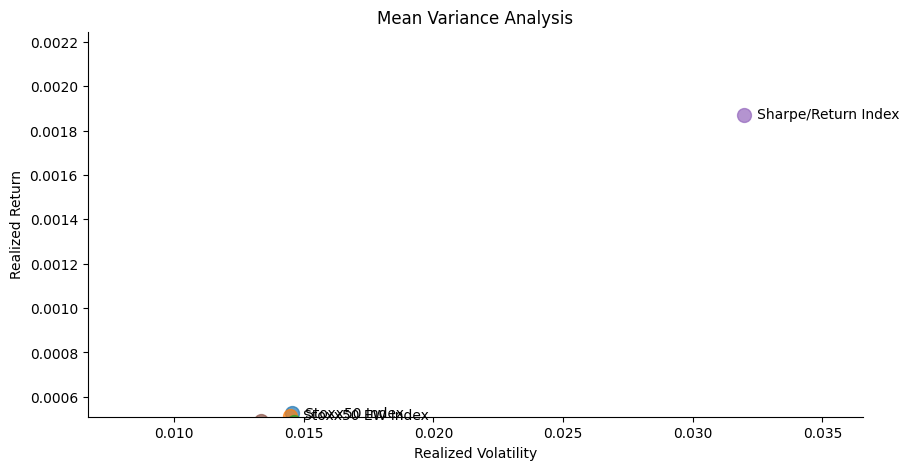

In [38]:
# mean variance analysis
comparison = {}

for i in ['SP100', 'equal', 'degeneracy', 'clique', 'sharpe', 'variance', 'return']:
    comparison[i] = (
        data[i].pct_change().dropna().std(),
        data[i].pct_change().dropna().mean()
    )

# visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter(
    comparison['SP100'][0], comparison['SP100'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['SP100'][0], comparison['SP100'][1]),
    text='   Stoxx50 Index', ha='left', va='center'
)

ax.scatter(
    comparison['equal'][0], comparison['equal'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['equal'][0], comparison['equal'][1]),
    text='   Stoxx50 EW Index', ha='left', va='center'
)

ax.scatter(
    comparison['degeneracy'][0], comparison['degeneracy'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['degeneracy'][0], comparison['degeneracy'][1]),
    text='   Degeneracy Index', ha='left', va='center'
)

ax.scatter(
    comparison['clique'][0], comparison['clique'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['clique'][0], comparison['clique'][1]),
    text='   Clique Index', ha='left', va='center'
)

ax.scatter(
    comparison['sharpe'][0], comparison['sharpe'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['sharpe'][0], comparison['sharpe'][1]),
    text='   Sharpe/Return Index', ha='left', va='center'
)

ax.scatter(
    comparison['variance'][0], comparison['variance'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['variance'][0], comparison['variance'][1]),
    text='Variance Index   ', ha='right', va='center'
)

ax.set_xlim(
    min([i[0] for i in comparison.values()]) * 0.5, 
    max([i[0] for i in comparison.values()]) * 1.05
)

ax.set_ylim(
    min([i[1] for i in comparison.values()]) * 1.05, 
    max([i[1] for i in comparison.values()]) * 1.2
)

ax.set_title('Mean Variance Analysis')
ax.set_xlabel('Realized Volatility')
ax.set_ylabel('Realized Return')

plt.show()
